In [32]:
# io stuff
from io_funcs import initialise_disk, IoSource, HD2236, DefinitelyRealIo, get_filter_spectrum, plot_params, plotting_io_comparison, get_residual_bounds, get_residuals

import os
os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import vmap, scipy as jsp, numpy as np, Array, random as jr
import dLux as dl
import dLux.utils as dlu
import dLuxWebbpsf as dlW
from zodiax.experimental import deserialise
import equinox as eqx

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors
from matplotlib.transforms import Affine2D
import ehtplot
from geckos_colourmap import geckos_div

# astronomy
from astropy.io import fits
from astropy import units as u
import webbpsf
from xara.core import determine_origin

# optimisation
import optax
from io_funcs import *
from optim_funcs import *

# AMIGO
from amigo.core import AMIOptics, SUB80Ramp, BaseModeller
from amigo.stats import check_symmetric, check_positive_semi_definite, total_read_noise, build_cov
from amigo.detector_layers import model_ramp
from amigo.fitting import optimise

# files
from zodiax.experimental import serialise, deserialise

# bruh
import numpy as onp

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
afmhot_10u = colormaps["afmhot_10u"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
afmhot_10u.set_bad("k", 0.5)


jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

sunset_dark = geckos_div(variation="geckos_sunset_darkred")
sunset = geckos_div(variation="geckos_sunset")

In [118]:
n_ios = 1
roll_angle_degrees = 26.5  # deg
ios = [DefinitelyRealIo(night_day_ratio=1, volc_contrast=1e-2, seed=2, n_volcanoes=3) for i in range(n_ios)]

In [47]:
# np.save("fake_io_noterm.npy", ios[1].data)
# canon_io = np.load("fake_io_noterm.npy")
canon_io = ios[0]

In [48]:
BFE = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_trained.zdx")
pupil_mask = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_AMI_mask.zdx")

In [49]:
# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
# inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )

detector = SUB80Ramp()

key = jr.PRNGKey(0)
ngroups = 3

params = {}
params["position"] = jr.uniform(key, (2,), minval=-0.5, maxval=0.5)
params["log_flux"] = jr.uniform(key, (1,), minval=6.9, maxval=7.1)
params["aberrations"] = 5*jr.normal(key, optics.coefficients.shape)
params["biases"] = 25*jr.normal(key, (80, 80)) + 80
params["OneOnFs"] = 10*jr.normal(key, (ngroups, 80, 2))
params["BFE"] = BFE
# params["aberrations"] = np.zeros(optics.coefficients.shape)
# params["biases"] = np.zeros((80, 80))
# params["OneOnFs"] = np.zeros((ngroups, 80, 2))
# params["BFE"] = PolyBFE(ksize=5, oversample=1, orders=[1, 2])
params["filter"] = get_filter_spectrum("F430M", file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/")
params["optics"] = optics
params["detector"] = detector
params["source"] = IoSource(
    position=params["position"],
    log_flux=params["log_flux"],
    distribution=canon_io.data,
    spectrum=params["filter"],
)
params["volcanoes"] = canon_io.volcanoes / canon_io.volcanoes.sum() # DO THIS IN THE CLASS
params["disk"] = canon_io.disk
params["volc_contrast"] = 5e-2
true_model = BaseModeller(params)

In [50]:
def model_fn(model, n_groups=ngroups, to_BFE=False):

    source = model.source.set(
        ["position", "log_flux"],
        [model.position, model.log_flux],
    )

    distribution = model.disk.data + model.volc_contrast * model.volcanoes
    source = source.set('distribution', distribution)  # ONLY FIT THE VOLCANOES

    # # Apply correct aberrations
    # optics = model.optics.set("coefficients", model.aberrations)

    # Make sure this has correct position units and get wavefronts
    PSF = source.model(optics, return_psf=True)

    # Apply the detector model and turn it into a ramp
    psf = model.detector.model(PSF)
    ramp = model_ramp(psf, n_groups)

    # if to_BFE:
    #     return ramp

    # Now apply the CNN BFE and downsample
    ramp = eqx.filter_vmap(model.BFE.apply_array)(ramp)
    ramp = vmap(dlu.resize, (0, None))(ramp, 80)

    # Apply bias and one of F correction
    ramp += total_read_noise(model.biases, model.OneOnFs)
    return ramp


In [51]:
def add_noise_to_ramp(clean_ramp):
    """
    Add poisson noise to the ramp.
    """
    ramp = []
    for i in range(len(clean_ramp)):
        seed = onp.random.randint(0, 100000)  # random seed for PRNGKey
        # if first group, just add poisson noise
        if i == 0:
            diff = jr.poisson(jr.PRNGKey(seed), clean_ramp[i])
            ramp.append(diff)
        # if not first group, add poisson noise on the new photons
        else:
            diff = jr.poisson(jr.PRNGKey(seed), clean_ramp[i] - clean_ramp[i - 1])
            ramp.append(ramp[-1] + diff)

    return np.array(ramp)

clean_int = model_fn(true_model, n_groups=ngroups)
data = add_noise_to_ramp(clean_int)  # adding photon noise to ramp
io_mask = np.where(initialise_disk()==0, False, True)

## Optimisation

In [52]:
def bias_prior(model, mean=80, std=50):
    # Estimated std is ~25, so we use 50 here to be conservative
    # Estimated mean is taken from the initial bias estimation
    bias_vec = model.biases
    return jsp.stats.norm.logpdf(bias_vec, loc=mean, scale=std).sum()

def norm_fn(model, args={}):
    """
    Method for returning a new source object with a normalised total
    spectrum and source distribution.

    Returns
    -------
    source : Source
        The source object with the normalised spectrum and distribution.
    """
    spectrum = model.spectrum.normalise()
    volc_contrast = np.maximum(model.volc_contrast, 0.)
    # distribution = np.maximum(model.distribution, 0.0)
    distribution = np.maximum(model.volcanoes, 0.0)    
    # distribution = model.volcanoes  

    # applying mask
    distribution = np.where(args['mask'], distribution, args['mask'])
    if distribution.sum != 0:
        distribution /= distribution.sum()

    return model.set(
        [
            "spectrum",
            "volcanoes",
            "volc_contrast",
            ],
        [
            spectrum,
            distribution,
            volc_contrast,
            ],
        )

# def grad_fn(grads, args={}, optimisers={}):
#     return grads.set('distribution', np.where(args['mask'], grads, args['mask']))

def L1_loss(model):
    dist = model.get('distribution')
    return np.sqrt(np.nansum(np.abs(dist)))

def loss_fn(model, args={}):
    data = args["data"]
    ramp = model_fn(model)
    loss = np.log10(-jsp.stats.norm.logpdf(ramp, data).sum())
    loss += args["L1"] * L1_loss(model)  # L1
    return loss


delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
adam_opt = lambda lr, start: optax.adam(delay(lr, start))
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))

In [100]:
initial_model = true_model.set(
    [
        "position",
        "log_flux",
        "distribution",
        "volcanoes",
        "volc_contrast",
        "aberrations",
        "biases",
        "OneOnFs"
    ],
    [
        true_model.position + 0.1*jr.normal(jr.PRNGKey(0), shape=(2,)),
        7.,
        initialise_disk(normalise=True),
        initialise_disk(normalise=True),
        0.95*true_model.volc_contrast,
        np.zeros_like(true_model.aberrations),
        np.zeros_like(true_model.biases),
        np.zeros_like(true_model.OneOnFs)
    ],
)

L1 = 0

config = {
    # # Crude solver
    # "distribution": opt(5e-7, 30),
    "volcanoes": opt(5e-5, 10),
    "volc_contrast": opt(1e-3, 30),
    "position": adam_opt(1e-2, 0),
    # "aberrations":  clip(opt(2e1, 100), 1),
    "log_flux": opt(2e-4, 0),
    
    # # Read noise refinement
    # "OneOnFs": clip(opt(5e0, 100), 1.0),
    # "biases": clip(opt(3e3, 100), 4.0),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    initial_model,
    # data,
    {"model_fn": model_fn, "data": data, "mask": io_mask, "L1": L1},
    loss_fn,
    2,
    config,
    norm_fn=norm_fn,
    # grad_fn=grad_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:08
Initial Loss: 9.83


Loss: 9.83, Change: 0.0:  50%|#####     | 1/2 [00:00<?, ?it/s]

Full Time: 0:00:10
Final Loss: 9.78


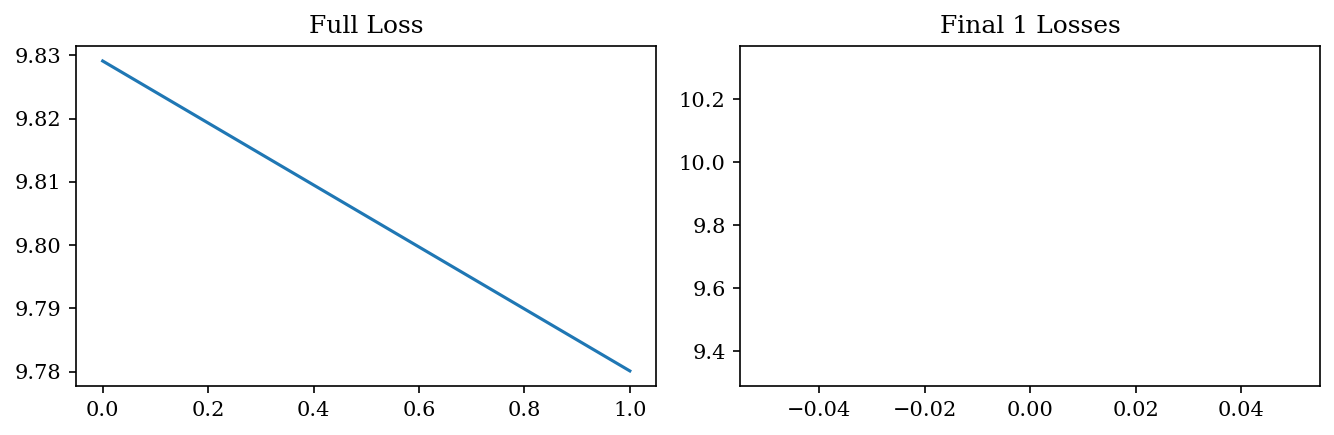

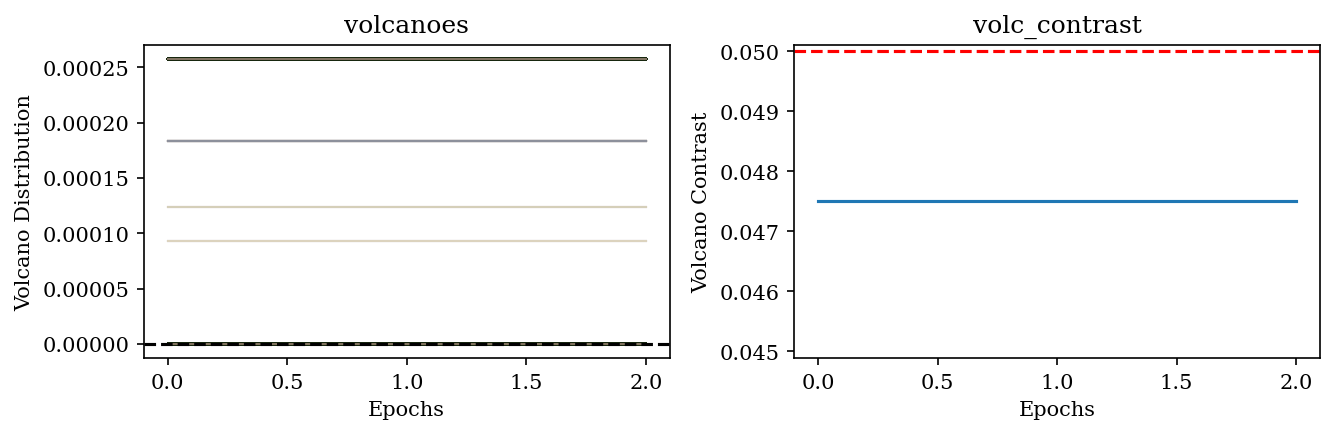

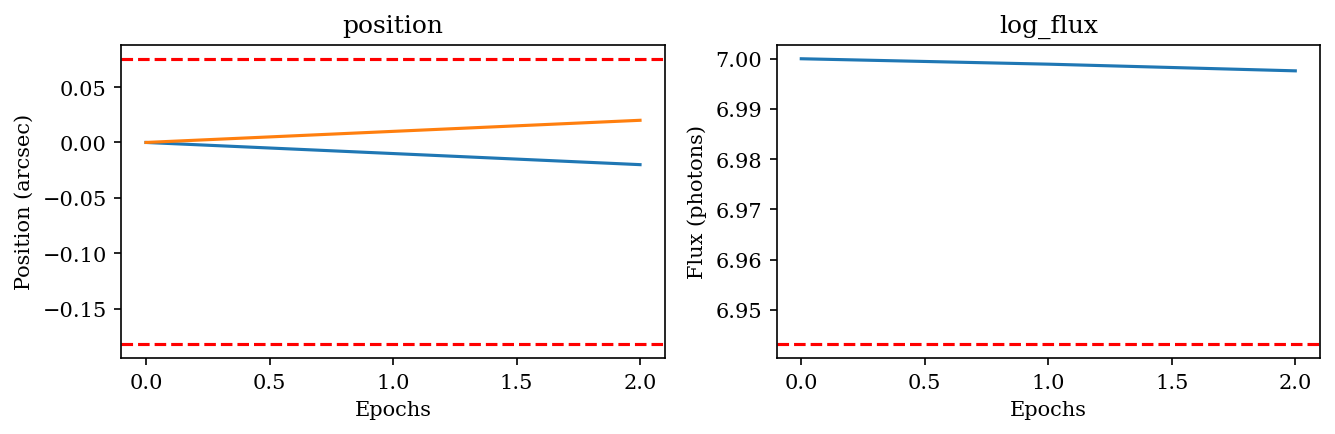

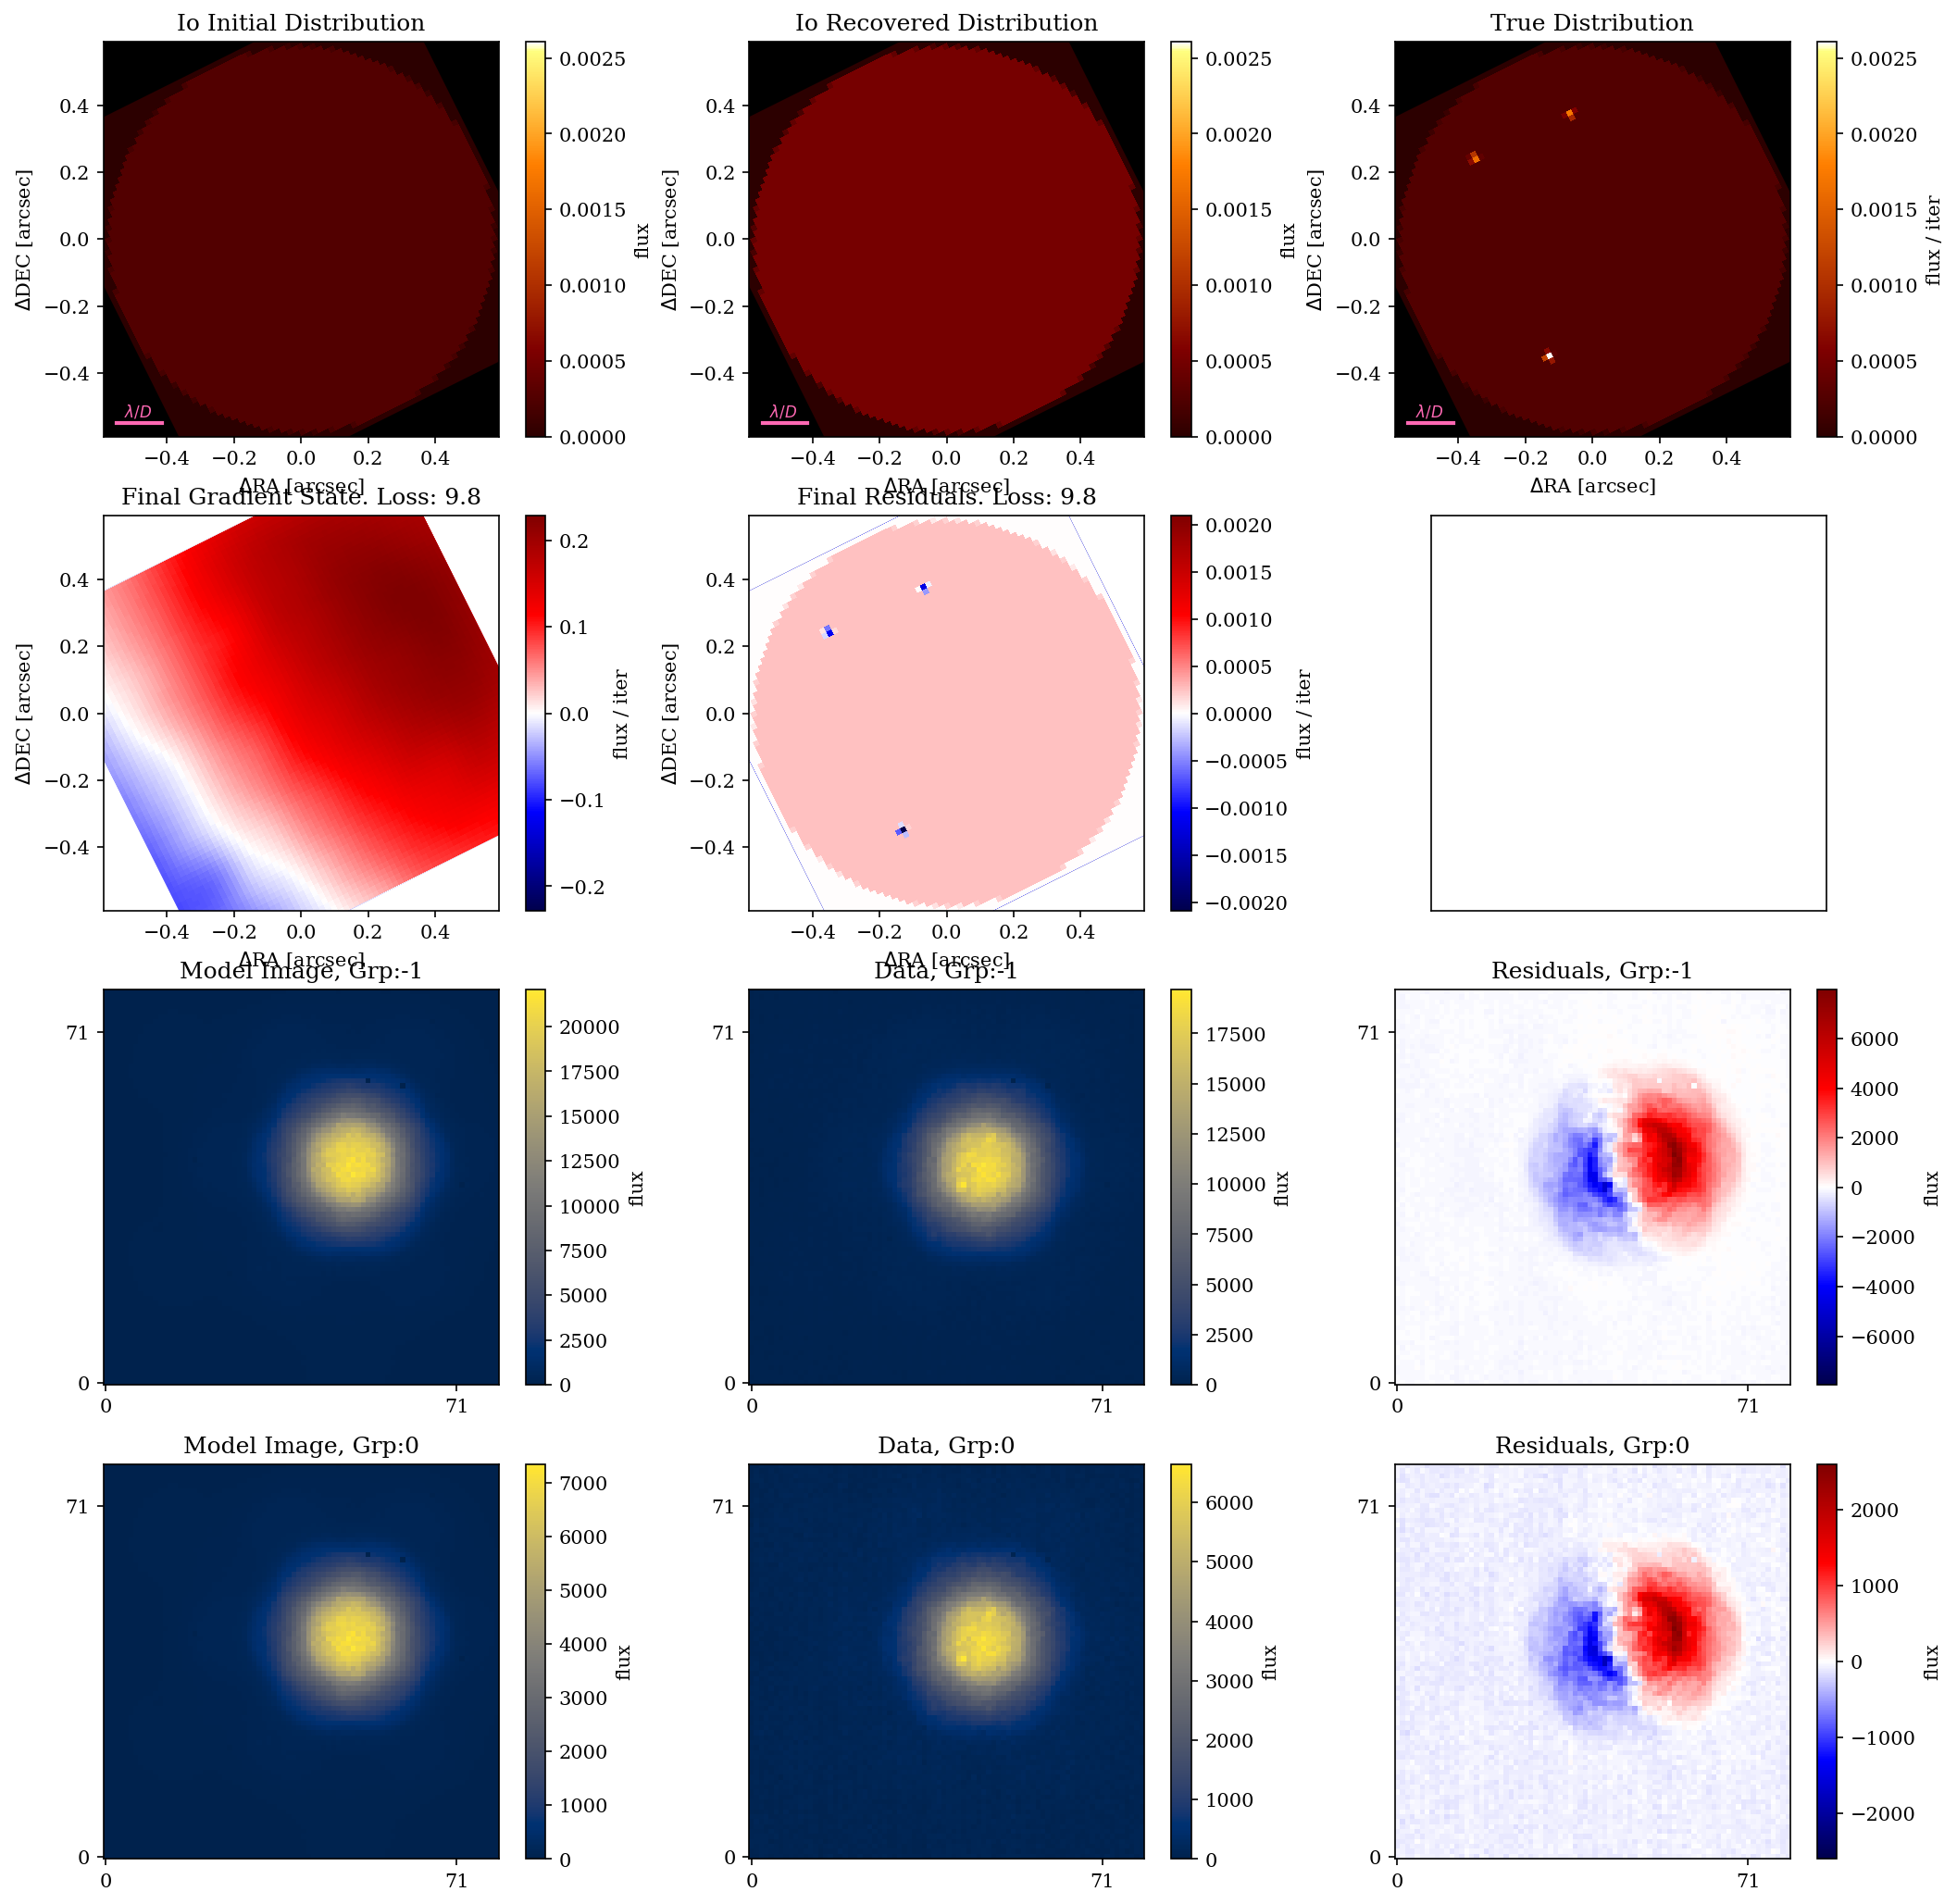

In [190]:
now = lambda: datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
save_path = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/output/" + now() + "/"

if not os.path.exists(save_path):
    os.makedirs(save_path)

plot_params(true_model, losses, params_out, format_fn, save=None)

plot_io_with_truth(
    final_model,
    model_fn,
    data,
    losses,
    ngroups,
    opt_state,
    initial_distribution=initial_model.source.distribution,
    truth=true_model.distribution,
    save=None,
    )
